<a href="https://colab.research.google.com/github/Vaelthur/DataSpaces_Tesina/blob/master/DS_Tesina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast cancer classification

## Table of Contents
0. [Introduction](#0.-Introduction)
1. [Imports Section](#1.-Imports-section)
2. [Functions](#2.-Functions)
3. [Data Acquisition & Description](#3.-Data-Acquisition-&-Description)
4. [Dataset Analisys](#4.-Dataset-Analisys)
5. [Preprocessing](#5.-Preprocessing)
6. [Classification & Parameters Tuning](#6.-Classification-&-Parameters-Tuning)

### 0. Introduction

The aim of this work is to classify breast cancer records in the provided dataset to determine wether a tumor is benignat or malignant. 
<br>
Features in this dataset are mostly referred to cells of the human body, describing their size, shape and characteristics. 

### 1. Imports section

In [0]:
# warning suppression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# general imports
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.base import clone
from scipy.spatial.distance import mahalanobis

# dataset balancing imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# classification imports 
from sklearn import neighbors, model_selection, metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# plots imports
import seaborn as sn
from matplotlib import pyplot as plt

### 2. Functions

Plotting function to show classifier in a graphic way: <br>
Trains classifier on just two parameters in order to show it in a 2-dimensional plot.

In [0]:
def plotClassifierResults(clf, title):
    X = X_train[:, :2]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
    
    clf.fit(X, Y_train)
    Z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z=Z.reshape(xx.shape)
    plt.figure(figsize=[10,10])
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=Y_train, cmap=plt.cm.RdYlGn, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Clump Thickness')
    plt.ylabel('Uniformity of Cell Shape')
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()

Check class balance function:
<br>
This function just takes in the target of the datset and plots the two possible clasisfications, then shows the percentages.

In [0]:
def checkClassBalance(data_tgt):
  class1 = data_tgt[data_tgt == 2]
  class2 = data_tgt[data_tgt == 4]
  plt.hist(class1, color='blue', width=0.5)
  plt.hist(class2, color='green', width=0.5)
  plt.show()
  print("Percentage of 2 and 4 are: ", class1.shape[0]/data_tgt.shape[0]*100, "% and ", class2.shape[0]/data_tgt.shape[0]*100,"%")

Find and remove outliers using Mahalanobis Distance functions
Apply this function just to the Training set.

This function calculates the Mahalanobis distance for each record in the dataset and then using the 68-95-99.7 rule calculates the standard deviation for this array and multiplies it by 2 (or 3 if we want to be in the <i>extreme</i> situation where we kepp the 99.7% of the dataset) and -2 to find the two thresholds. If some value of the distance vector goeas over or upper these thresholds it is considered as an outlier and thus taken out.

In [0]:
def mahalanobisDist(X,meanCol,IC):
  # calculate Mahalanobis distance for each row of the dataset
    m = []
    for i in range(X.shape[0]):
        m.append(mahalanobis(X.iloc[i,:],meanCol,IC) ** 2)
    return(m)

def detectOutliersMD(MD, data, extreme=False):
  std = np.std(MD)

  # I'll use te 68-95-99.7 rule to detect outliers

  k = 3. *std if extreme else 2. * std
  m = np.mean(MD)
  up_t = m+k
  low_t = m-k 

  outliers = []

  for i in range(len(MD)):
    if (MD[i] >= up_t or MD[i] <= low_t):
      outliers.append(i) #index
  return np.array(outliers)

def detectAndDeleteOutliers(data, tgt):

  CM = data.cov().values # covariance matrix
  ICM = sp.linalg.inv(CM) # inverse of the covariance matrix

  mean = data.mean().values # mean of each feature

  mD = mahalanobisDist(data,mean,ICM) # array of mahalanobis distances

  outliers = detectOutliersMD(mD, data)

  # perform a reset index on data to return to avoid crashes and errors
  cleanDs = data.reset_index(drop=True)
  cleanTgt = tgt.reset_index(drop=True)

  # drop index outliers in both data and target
  cleanDs = cleanDs.drop(index=outliers)
  cleanTgt = cleanTgt.drop(index=outliers)

  print("Training dataset size before OutlierDetection: ", data.shape[0], "\nTraining dataset size after OutlierDetection: ", cleanDs.shape[0])

  return cleanDs, cleanTgt


### 3. Data Acquisition & Description

<p> Read .csv file <p>

In [0]:
# read data from file
filename = "https://raw.githubusercontent.com/Vaelthur/DataSpaces_Tesina/master/breast-cancer-wisconsin.data"

data = pd.read_csv(filename)

labels = ["Sample Number","Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", 
"Mitoses", "Class"]

# assing labels to columns
data.columns = labels

# records with the classification as "2" are Benign cancer, "4" means malign Cancer.

<b>Dataset feature description and analisys<b>

- **Sample code number**: code number used to identify patients 
- **Clump Thickness**: Benign cells tend to be grouped in monolayers, while cancerous cells are often grouped in multilayers. 
- **Uniformity of Cell Size**: Cancer cells tend to vary in size
- **Uniformity of Cell Shape**: Cancer cells tend to vary in shape
- **Marginal Adhesion**: Normal cells tend to stick together. Cancer cells tends to lose this ability: loss of adhesion is a sign of malignancy. 
- **Single Epithelial Cell Size**: related to the uniformity mentioned above. Epithelial cells that are significantly enlarged may be malignant. 
- **Bare Nuclei**: Nuclei which are not surrounded by cytoplasm (i.e. the rest of the cell). Those are typically seen in benign tumors.
- **Bland Chromatin**: Describes a uniform "texture" of the nucleus seen in benign cells. In cancer cells the chromatin tends to be more coarse
- **Normal Nucleoli**:  Nucleoli are small structures seen in the nucleus. In normal cells the nucleolus is usually very small if visible at all. In cancer cells the nucleoli become more prominent, and sometimes there are more of them.
- **Mitoses**: Nuclear division plus cytokinesis which produces two identical cell daughters. Mitosis is more frequent and disregulated in cancer cells than in healthy ones
- **Class**: classification of the cancer : 2 for benign, 4 for malignant


### 4. Dataset Analisys

Detecting if there are any missing value 

In [6]:
print("Raw data shape as taken from repo:")
print(data.shape)
data = (data.drop(labels,axis=1)).join(data[labels].apply(pd.to_numeric, errors='coerce'))
data = data[data[labels].notnull().all(axis=1)]
print("\nData shape without null values")
print(data.shape)

# remove first column as it is just sample number that identify the patient
data = data.iloc[:, 1:11]
print("\nData shape without first Column \"Sample Number\" which is just a number that identifies the patient and is not useful for us.")
print(data.shape)

Raw data shape as taken from repo:
(698, 11)

Data shape without null values
(682, 11)

Data shape without first Column "Sample Number" which is just a number that identifies the patient and is not useful for us.
(682, 10)


As stated in the dataset description there should have been some missing values, denoted by the non numerical value <i>'?'</i>. Knowing this I have been able to perform the search for missing value just looking for non-numerical values and (since there were just 16) dropping the corresponding rows. 

Plotting the distribution between the two classes in the dataset and observe the results.

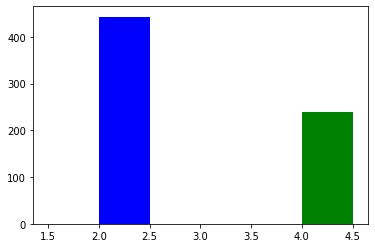

Percentage of 2 and 4 are:  64.95601173020528 % and  35.043988269794724 %


In [7]:
clss = data.iloc[:, 9]
checkClassBalance(clss)

Observing the percentage of the two classes we can identify this dataset as imbalanced since the two classes go over the 60/40 ratio so it's not acceptable and we need to provide some more balance i.e.
- undersample out dataset in order to achieve the balance between classes
- using library to artificially generate data to balance class, but new data must only be used during the training process and not during validation or test phases.

<p>Correlation Matrix to study correlation between data.</p>

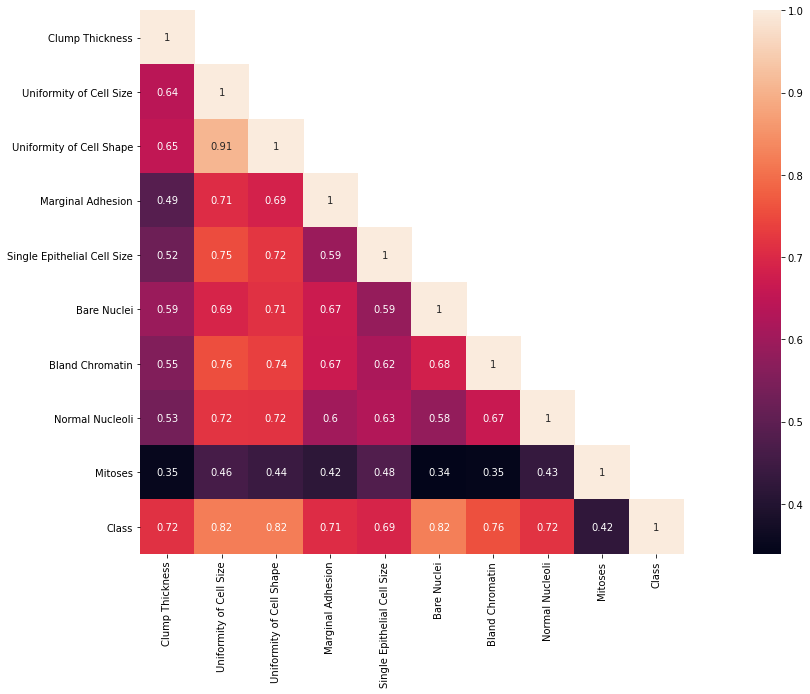

In [8]:
cm = data.corr() # Compute pairwise correlation of columns
mask = np.array(cm)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(25,10)
sn.heatmap(data=cm, mask=mask, square=True, annot=True, cbar=True)

We can observe that the correlation coefficients are generally good, with the Mitoses feature to be the more uncorrelated with a coeffient of 0.42.
Thanks to this matrix we can see which features are more correlated with each other respect to others. We notice from here that <i>Uniformity of cell size</i> and <i>Uniformity of cell shape</i> features are highly correlated with each other, so we can drop one.

In [0]:
data.drop('Uniformity of Cell Size', axis=1, inplace=True)

Reading the dataset description and observing the values inside it we can see that every feature is already scaled in a range between 1 and 10, so we can affirm that data is already scaled because we have the same scale for each feature. (Plus we don't need to operate further scaling to the data before applying the SVM with the RBF kernel)

Knowing this, the <b>preprocessing</b> phase consist just in the split between train and Test sets and the further Train set balancing.

### 5. Preprocessing

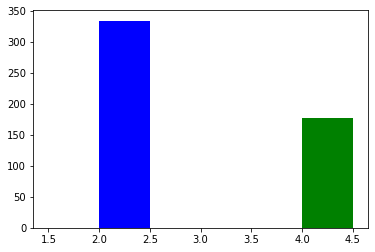

Percentage of 2 and 4 are:  65.36203522504891 % and  34.63796477495107 %

Training dataset size before OutlierDetection:  511 
Training dataset size after OutlierDetection:  482



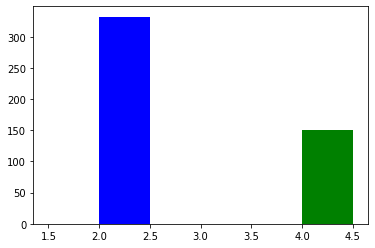

Percentage of 2 and 4 are:  68.87966804979253 % and  31.12033195020747 %


In [10]:
Y = data.iloc[:, 8]
X = data.iloc[:, 0:8]

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state=np.random.randint(0,100), test_size=0.25, shuffle=True)

checkClassBalance(Y_train)
print()

X_train, Y_train = detectAndDeleteOutliers(X_train, Y_train)

print()
checkClassBalance(Y_train)

Now that I have observed the difference in distribution between the two classes in my training set I have two options: I can either undersample my dataset or artifically augment it in order to have more training samples.

In the following I tried to augment my data using SMOTE to generate new samples, but I noticed that many algorithms overfit with this method, so I'll try undersampling my data instead of augmenting it.

In [0]:
# 1st attempt: augment training data and go on with classification

# oversample = SMOTE()
# X_train, Y_train = oversample.fit_resample(X,Y)

# checkClassBalance(Y_train)

# OVERFITS

Here I will undersample my datasets by taking out some samples from the majority class in order to even it with the minority class, since the artificial augmentation of the dataset had my classifiers overfit.

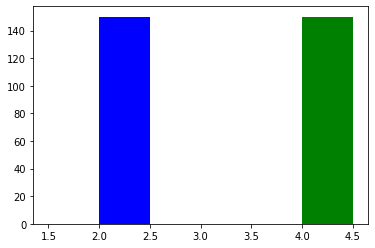

Percentage of 2 and 4 are:  50.0 % and  50.0 %


In [12]:
rus = RandomUnderSampler(random_state=0)
X_train, Y_train = rus.fit_resample(X_train, Y_train)

checkClassBalance(Y_train)

In the following cells we will analysze how well classifiers do with our dataset. In order to do so we will pay attention especially to values of precision and recall, more than to the overall accuracy.
<br>
Let's give some informations about these two parameters: 

<i>Precision</i>: this value is given by the formula TP/(TP+FP) and answers the question "What percentage of positive classifications were actually correct?"

<i>Recall</i>: this value s given by the formula TP/(TP+FN) and answers the question "What percentage of actual positives were classified correctly?"

In order to evaluate the best performance we will focus more on the precision and recall values for what concerns the class '4' that are malignant tumors. This is because it is more important to find out is a tumor is malignant than if it is benignant. 
<br>

###6. Classification & Parameters Tuning

<u>Logistic Regression</u>

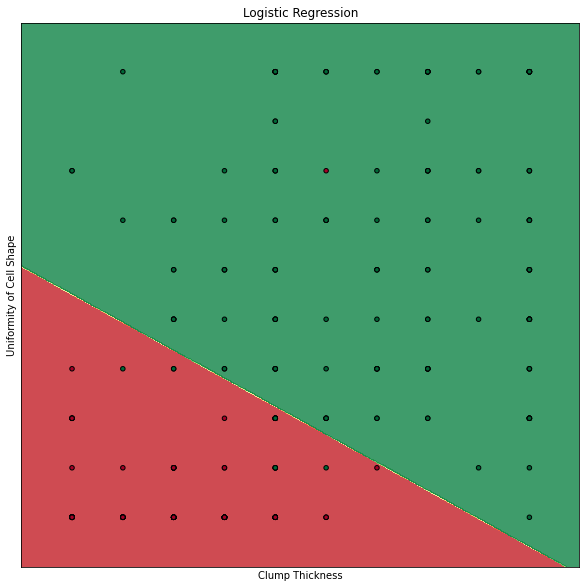

Accuracy:  0.9766081871345029
              precision    recall  f1-score   support

           2       0.98      0.98      0.98       109
           4       0.97      0.97      0.97        62

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



In [13]:
logReg = LogisticRegression() # instance of the model

# cross validation to prevent overfitting
kf = model_selection.KFold(n_splits=5)

accuracy = []

for tr_ind, te_ind in kf.split(X_train):
  X_t, X_v = X_train[tr_ind], X_train[te_ind]
  Y_t, Y_v = Y_train[tr_ind], Y_train[te_ind]
  logReg.fit(X_t, Y_t)
  accuracy.append(metrics.accuracy_score(Y_v, logReg.predict(X_v), normalize=True)*100)

logReg2 = clone(logReg)

plotClassifierResults(logReg2, "Logistic Regression")

print("Accuracy: ", logReg.score(X_test, Y_test))
print(classification_report(Y_test, logReg.predict(X_test)))

Almost no parameter tuning for Logistic Regression is possible, so I'll just try differe numbers for the max_iterations parameter (200 and 500 besides the default 100 iterations)

In [14]:
parameters = [{'max_iter' : [200, 500]}]

lrGS = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1, cv=5)

# Here the function GridSearch CV already performs a KFold cross validation on the dataset
lrGS.fit(X_train, Y_train)

print(classification_report(Y_test, lrGS.predict(X_test)),"\n")

print("Best parameters are: ",lrGS.best_params_)

              precision    recall  f1-score   support

           2       0.98      0.98      0.98       109
           4       0.97      0.97      0.97        62

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171
 

Best parameters are:  {'max_iter': 200}


<u> Random forest</u>

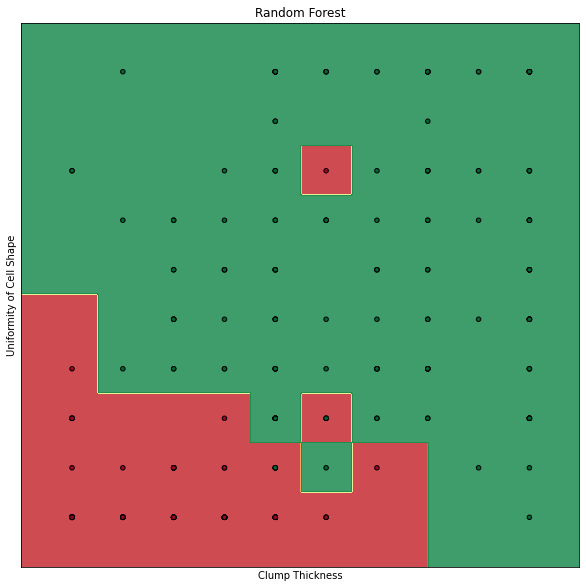


Accuracy:  0.9707602339181286
              precision    recall  f1-score   support

           2       0.97      0.98      0.98       109
           4       0.97      0.95      0.96        62

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [15]:
rndFor = RandomForestClassifier()

accuracy = []

for tr_ind, te_ind in kf.split(X_train):
  X_t, X_v = X_train[tr_ind], X_train[te_ind]
  Y_t, Y_v = Y_train[tr_ind], Y_train[te_ind]
  rndFor.fit(X_t, Y_t)
  accuracy.append(metrics.accuracy_score(Y_v, rndFor.predict(X_v), normalize=True)*100)

y_pred = rndFor.predict(X_test)

rndFor2 = clone(rndFor)

plotClassifierResults(rndFor2, 'Random Forest')

print("\nAccuracy: ", metrics.accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, rndFor.predict(X_test)))

Those were the results without any kind of parameter tuning and optimization. Now I will perform a GridSearchCrossValidation for the randomForest classifier using different set of paramteres.

In [16]:
parameters = [{'n_estimators': [50,100,200], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 5], 'max_features': ['sqrt', 'log2']}]
rfGS = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)

# Here the function GridSearch CV already performs a KFold cross validation on the dataset
rfGS.fit(X_train, Y_train)

print(classification_report(Y_test, rfGS.predict(X_test)),"\n")

print("Best parameters are: ",rfGS.best_params_)

              precision    recall  f1-score   support

           2       0.99      0.98      0.99       109
           4       0.97      0.98      0.98        62

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171
 

Best parameters are:  {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 50}


<p><u> SVM</u> </p>

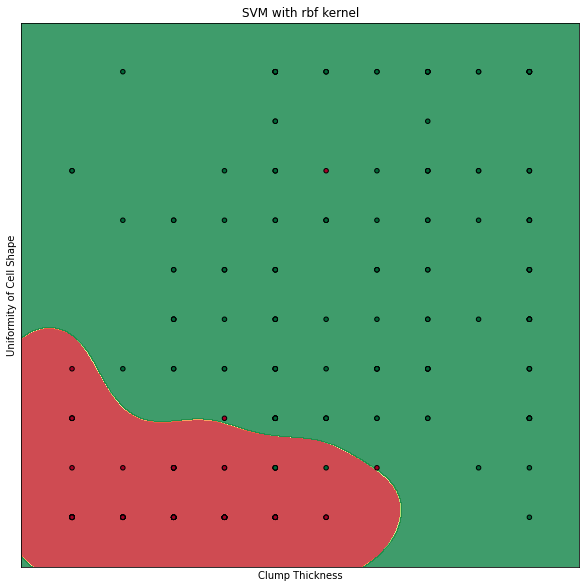

              precision    recall  f1-score   support

           2       1.00      0.97      0.99       109
           4       0.95      1.00      0.98        62

    accuracy                           0.98       171
   macro avg       0.98      0.99      0.98       171
weighted avg       0.98      0.98      0.98       171
 



In [17]:
svc = SVC(gamma='auto', kernel='rbf')
kf = model_selection.KFold(n_splits=7)

accuracy = []

for tr_ind, te_ind in kf.split(X_train):
  X_t, X_v = X_train[tr_ind], X_train[te_ind]
  Y_t, Y_v = Y_train[tr_ind], Y_train[te_ind]
  svc.fit(X_t, Y_t)
  accuracy.append(metrics.accuracy_score(Y_v, svc.predict(X_v), normalize=True)*100)

svc2 = clone(svc)

plotClassifierResults(svc2, 'SVM with rbf kernel')

print(classification_report(Y_test, svc.predict(X_test)),"\n")

So this is the accuracy with the default parameters, but it is necessary to perform some parameters tuning in order to achieve better results.



In [18]:
parameters = [{'C': [0.1, 0.2, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.25, 1], 'kernel': ['rbf', 'poly']}]
svcGS = GridSearchCV(SVC(), parameters, n_jobs=-1, cv=7)

# Here the function GridSearch CV already performs a KFold cross validation on the dataset
svcGS.fit(X_train, Y_train)

print(classification_report(Y_test, svcGS.predict(X_test)),"\n")

print("Confusion Matrix")
print(metrics.confusion_matrix(Y_test, svcGS.predict(X_test)))

print("Best parameters are: ",svcGS.best_params_)

              precision    recall  f1-score   support

           2       0.99      0.98      0.99       109
           4       0.97      0.98      0.98        62

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171
 

Confusion Matrix
[[107   2]
 [  1  61]]
Best parameters are:  {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
